__<h1><center>ML Zoomcamp 2023 - Homework #4</center></h1>__

In [96]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split,  KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

In [97]:
#@ IMPORTING DATASET:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
select_cols = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", 
               "highway MPG", "city mpg", "MSRP"]
data = pd.read_csv(url, usecols=select_cols)

In [98]:
data.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


__Data preparation__

In [99]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [100]:
print(data.shape)

(11914, 10)


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11845 non-null  float64
 4   engine_cylinders   11884 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [102]:
selected_features = ['engine_hp', 'engine_cylinders']
data[selected_features] = data[selected_features].fillna(0) #Fill in the missing values of the selected features with 0

# Rename 'MSRP' to 'price'
data = data.rename(columns={'msrp': 'price'})

In [103]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


__Make price binary__

Now we need to turn the price variable from numeric into a binary format.
Let's create a variable above_average which is 1 if the price is above its mean value and 0 otherwise.

In [104]:
# Calculate the mean of the 'price' column
mean_price = data['price'].mean()

# Create a new column 'above_average' based on the condition
data['above_average'] = (data['price'] > mean_price).astype(int)

In [105]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


__Split the Data into Train/Validation/Test Sets:__

In [106]:
train_val, test = train_test_split(data, test_size=0.2, random_state=1)
train, val = train_test_split(train_val, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

__Question 1: ROC AUC feature importance__

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* engine_hp
* engine_cylinders
* highway_mpg
* city_mpg

In [107]:
# Define the variables
numerical_variables = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

# Initialize a dictionary to store AUC scores
auc_scores = {}

# Calculate AUC for each numerical variable
for var in numerical_variables:
    auc = roc_auc_score(train['above_average'], train[var])
    
    # If AUC is less than 0.5, negate the variable
    if auc < 0.5:
        auc = roc_auc_score(train['above_average'], -train[var])
    
    auc_scores[var] = auc

# Find the variable with the highest AUC
highest_auc_variable = max(auc_scores, key=auc_scores.get)
highest_auc_value = auc_scores[highest_auc_variable]

print(f"The variable with the highest AUC is '{highest_auc_variable}' with a value of {highest_auc_value}.")


The variable with the highest AUC is 'engine_hp' with a value of 0.9171031265539011.


/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `

__Question 2: Training the model__

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.678
* 0.779
* 0.878
* 0.979

In [108]:
# Select the features and target variable
features = [
    'make', 'model', 'year', 'engine_hp', 'engine_cylinders','transmission_type', 'vehicle_style',
    'highway_mpg', 'city_mpg'
]

target = 'above_average'

# Create a DictVectorizer
dv = DictVectorizer(sparse=False)

# Apply one-hot-encoding to the training and validation data
X_train = dv.fit_transform(train[features].to_dict(orient='records'))
X_val = dv.transform(val[features].to_dict(orient='records'))

# Initialize and train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, train[target])

# Predict probabilities on the validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate AUC on the validation set
auc = roc_auc_score(val[target], y_pred_proba)

print(f"The AUC of the model on the validation dataset is: {auc:.3f}")


The AUC of the model on the validation dataset is: 0.976


/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anastasia_lukashenko/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `

__Question 3: Precision and Recall__

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

/var/folders/4z/rp2w0qyd2pn083mlw17379500000gn/T/ipykernel_16313/2650629912.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


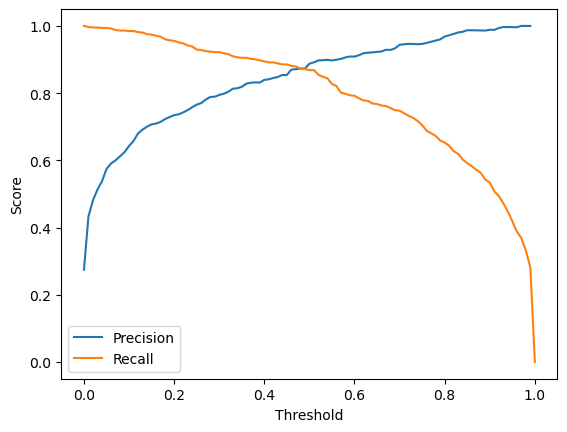

The manually chosen threshold is: 0.48


In [109]:
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((val[target] == 1) & (y_pred == 1))
    fp = np.sum((val[target] == 0) & (y_pred == 1))
    fn = np.sum((val[target] == 1) & (y_pred == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

manual_threshold = 0.48
print(f"The manually chosen threshold is: {manual_threshold:.2f}")



__Question 4: F1 score__

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 ((R*P) / (R+P))

Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.12
* 0.32
* 0.52
* 0.72

In [110]:
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((val[target] == 1) & (y_pred == 1))
    fp = np.sum((val[target] == 0) & (y_pred == 1))
    fn = np.sum((val[target] == 1) & (y_pred == 0))
    
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    f1_scores.append(f1)

# Find the threshold where F1 score is maximal
best_threshold_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"The threshold where F1 score is maximal is: {best_threshold:.2f}")


The threshold where F1 score is maximal is: 0.51


__Question 5: 5-Fold CV__

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:


KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

* 0.003
* 0.030
* 0.090
* 0.140

__Question 6: Hyperparemeter Tuning__ 

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

* 0.01
* 0.1
* 0.5
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [111]:
train_features = dv.transform(train[features].to_dict(orient='records'))


In [112]:
# Define the list of C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Initialize KFold with 5 splits, shuffle=True, and random_state=1
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a dictionary to store mean scores and standard deviations
results = {}

# Iterate over different C values
for C in C_values:
    auc_scores = []
    
    # Iterate over different folds
    for train_idx, val_idx in kf.split(train_features):
        X_train_fold, X_val_fold = train_features[train_idx], train_features[val_idx]
        y_train_fold, y_val_fold = train[target].values[train_idx], train[target].values[val_idx]

        # Initialize and train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation set
        y_pred_proba_fold = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC on the validation set
        auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        auc_scores.append(auc_fold)
    
    # Calculate mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store results
    results[C] = (mean_auc, std_auc)

# Find the best C based on mean score, with tiebreakers as specified
best_C = min(results, key=lambda k: (results[k][0], results[k][1], k))

# Get the mean score and std for the best C
best_mean_score, best_std = results[best_C]

# Print the results
print(f"The best C value is: {best_C}")
print(f"Mean AUC score for the best C: {best_mean_score:.3f}")
print(f"Standard deviation for the best C: {best_std:.3f}")


The best C value is: 0.01
Mean AUC score for the best C: 0.949
Standard deviation for the best C: 0.003
